In [20]:
import cv2
from cv2 import imread, imwrite, resize, imshow
import matplotlib.pyplot as plt
#from PIL import Image
from math import ceil
from time import time
from pandas import DataFrame
import glob
import os
from pathlib import Path
import shutil

import tkinter as tk
from tkinter import filedialog

import numpy as np

from datetime import datetime

from copy import deepcopy

size = 416 #tile image size 416 x 416
tile_overlap_ratio = 0.25
conf_thres = 0.25
nms_thres = 0.1
root = tk.Tk()
root.withdraw()

''

In [223]:
def create_mask(img):
    #convert to grayscale image
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #Gaussian blur
    img_blur = cv2.GaussianBlur(img_gray,(15,15),10)
    #thresholding using auto threshold Triangle
    threshold,thresholded_image = cv2.threshold(img_blur,50,255,cv2.THRESH_BINARY+cv2.THRESH_TRIANGLE)  
    #fill holes by closing operation (dilation followed by erosion) 
    closed = cv2.morphologyEx(thresholded_image, cv2.MORPH_CLOSE, np.ones((20,20),np.uint8))
    #remove noise by erosion
    mask1 = cv2.erode(closed, np.ones((30,30),np.uint8),iterations = 1)
    """
    #remove noise by opening (erosion followed by dilation)
    opening = cv2.morphologyEx(thresholded_image, cv2.MORPH_OPEN, np.ones((30,30),np.uint8))
    #fill holes by dilation
    mask= cv2.dilate(opening, np.ones((30,30),np.uint8),iterations = 1)
    """
    #create a rectangular mask
    h, w, _ = img.shape
    rec_mask = np.zeros((h,w), np.uint8)
    rec_mask[ceil(h/4):ceil(3*h/4),ceil(w/4):ceil(3*w/4)] = 255
    # combine mask1 and rectangular mask to create final mask2
    mask2 = cv2.bitwise_and(mask1,rec_mask)
    # plot image and mask2
    plt.subplot(1,2,1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.subplot(1,2,2)
    plt.imshow(cv2.cvtColor(mask2, cv2.COLOR_BGR2RGB))
    plt.show()
    return mask2

In [224]:
def start_points(size, split_size, overlap=0):
    points = [0]
    stride = int(split_size * (1-overlap))
    counter = 1
    while True:
        pt = stride * counter
        if pt + split_size >= size:
            if split_size == size:
                break
            points.append(size - split_size)
            break
        else:
            points.append(pt)
        counter += 1
    return points

In [225]:
def nms(dets, thresh):
    x1 = dets[:, 0]
    y1 = dets[:, 1]
    x2 = dets[:, 2]
    y2 = dets[:, 3]
    scores = dets[:, 4]

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)

        inds = np.where(ovr <= thresh)[0]
        order = order[inds + 1]

    return keep

In [226]:
def datapipeline(file_path):
  '''
  This function takes image path 
  and image names as arguments
  and divides the images into 
  blocks (tiles) and detects 
  objects in individual
  blocks (tiles). Finally, the 
  blocks are stitched 
  together and detected images
  are displayed.
  '''
  
  colors = [
      (0,0,255),
  ]

  obj_names = [
             "positive"
  ]
  
  # read .jpg image and make tiles each of dimensions size x size
  print(file_path)
  im_name = Path(file_path).stem  #get name of image
  ext = Path(file_path).suffix    #get extension of image
  print(im_name + ext)
  im = imread(file_path) #read the image 
  h, w, _ = im.shape
  h_new = ceil(h/size) * size
  w_new = ceil(w/size) * size
  scale_h = h_new/h
  scale_w = w_new/w
  resized_im = im # resize(im, (w_new, h_new), cv2.INTER_LINEAR) # resize the image
  #create a subfolder yolov5/tiled_images/ to store tiled images
  tiled_images_path = "C:/Users/Hoan Ngo/yolov5/tiled_images/"  
  #tiled_images_path = "C:/Users/ngoth/yolov5/tiled_images/"
  print(tiled_images_path)
  if os.path.exists(tiled_images_path) == True:
      try:
          shutil.rmtree(tiled_images_path)
          os.mkdir(tiled_images_path)
      except OSError as error: 
          print(error) 
  else:
      try:
          os.mkdir(tiled_images_path)
      except OSError as error: 
          print(error) 

  tiled_ims_list = []
  # create tiled images
  X_points = start_points(w_new, size, tile_overlap_ratio)
  Y_points = start_points(h_new, size, tile_overlap_ratio)
  for i in Y_points:
    for j in X_points:
      tiled = resized_im[i:i+size, j:j+size, :]
      #file path of each tiled image, e.g. yolov5/tiled_images/im_name_i_j.jpg
      tiled_im_name = tiled_images_path + im_name + "__" + str(i) + "__" + str(j) + ext
      #store file path of tiled image to a list
      tiled_ims_list.append(tiled_im_name)
      # saving tiled image
      imwrite(tiled_im_name, tiled)
  df = DataFrame(tiled_ims_list)
  # saving the file path of the tiled image to the file file_path/tiled_images.txt
  df.to_csv(tiled_images_path + "tiled_images.txt", index = False, header = False)
  # detect objects on individual tiles and store detected objects in json format
  start = time()
  !python "C:/Users/Hoan Ngo/yolov5/detect.py" --weights "C:/Users/Hoan Ngo/yolov5/best150epochondatasetv5_mAP_99_55.pt" --img 416 --conf-thres 0.25 --iou-thres 0.1 --save-txt --save-conf --source "C:/Users/Hoan Ngo/yolov5/tiled_images/" --project "C:/Users/Hoan Ngo/yolov5/tiled_images/" --hide-labels
  #!python "C:/Users/ngoth/yolov5/detect.py" --weights "C:/Users/ngoth/yolov5/best150epochondatasetv5_mAP_99_55.pt" --img 416 --conf-thres 0.5 --iou-thres 0.1 --save-txt --save-conf --source "C:/Users/ngoth/yolov5/tiled_images/" --project "C:/Users/ngoth/yolov5/tiled_images/" --hide-labels
  end = time()

In [227]:
def display(file_path):    
    ext = file_path.split(".")[-1]
    im = imread(file_path)
    mask = create_mask(im) #create a mask
    h, w, _ = im.shape
    h_new = ceil(h/size) * size
    w_new = ceil(w/size) * size
    scale_h = h_new/h
    scale_w = w_new/w
    resized_im = im #resize(im, (w_new, h_new), cv2.INTER_LINEAR)
    annotations_list = []
    dets = []
    num_pos_wells = 0
    for label_file_path in glob.glob("C:/Users/Hoan Ngo/yolov5/tiled_images/exp/labels/*.txt"):
      label_file_name = Path(label_file_path).stem #get name of label file
      #print(label_file_name)
      im_index_i = label_file_name.split("__")[1] #i is index of row -> y
      im_index_j = label_file_name.split("__")[2] #j is index of col -> x
      with open(label_file_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
          cls, x, y, w, h, conf = line.split() # x and y are coordinates of the center of the object
          x_abs = int(im_index_j) + float(x)*size  # convert to coordinate in original image
          y_abs = int(im_index_i) + float(y)*size  # convert to coordinate in original image
          x1 = round(x_abs - float(w)*size/2)
          y1 = round(y_abs - float(h)*size/2)
          start_point = (x1, y1)
          x2 = round(x_abs + float(w)*size/2)
          y2 = round(y_abs + float(h)*size/2)
          end_point = (x2, y2)
          #annotations_list.append([cls, x_abs, y_abs, w, h, conf])  # "class", "x", "y", "w", "h", "obj_name", "confidence"
          dets.append([x1, y1, x2, y2, float(conf)]) 
    #use non maximum suppression to remove overlap bounding boxes
    #print(np.array(dets))
    if len(dets) > 0:
        keep = nms(np.array(dets), nms_thres)
        #print(keep)
        #plot bounding boxes on input image

        #should plot before and after nms......
        resized_im_2 = deepcopy(resized_im)
        for box in keep:
            if mask[dets[box][1],dets[box][0]] == 255 and mask[dets[box][3],dets[box][2]] == 255:
                cv2.rectangle(resized_im, (dets[box][0],dets[box][1]), (dets[box][2],dets[box][3]),(0,255,0),3)
                cv2.rectangle(resized_im_2, (dets[box][0],dets[box][1]), (dets[box][2],dets[box][3]),(0,255,0),3)
                cv2.putText(resized_im_2, str(round(dets[box][4],2)), (dets[box][0],dets[box][1]-2), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)
                annotations_list.append([dets[box][0], dets[box][1], dets[box][2], dets[box][3], dets[box][4]])  # "x1", "y1", "x2", "y2", "confidence"
                num_pos_wells += 1
        #window_name = 'image'
        #imshow(window_name,resized_im)
        now = datetime.now() # current date and time
        date_time = now.strftime("%m_%d_%Y_%H_%M_%S")
        output_folder = file_path.replace("." + ext,"_output " + date_time + "/") #create output folder
        try:
              os.mkdir(output_folder)
        except OSError as error: 
              print(error)
        #save and show image
        output_image_file_path = output_folder + "output_image." + ext
        imwrite(output_image_file_path, resized_im)
        output_image_file_path = output_folder + "output_image_with_conf." + ext
        imwrite(output_image_file_path, resized_im_2)
        plt.axis("off")
        plt.imshow(cv2.cvtColor(resized_im, cv2.COLOR_BGR2RGB))
        plt.show()
        #save number of positive wells to text file
        summary_file_path = output_folder + "summary.txt"
        summary_dict = {"tile_grid_size": size, "tile_overlap_ratio": tile_overlap_ratio, "conf_threshold": conf_thres, "nms_threshold": nms_thres, "num_pos_wells" : num_pos_wells}
        file = open(summary_file_path, "w")
        file.write(repr(summary_dict))
        print(summary_dict)
        # waits for user to press any key
        # (this is necessary to avoid Python kernel form crashing)
        #cv2.waitKey(0)
        # closing all open windows
        #cv2.destroyAllWindows()
        #save annotation list 
        df = DataFrame(annotations_list)
        annotation_list_path = output_folder + "annotationlist.txt"
        # saving the location of detected objects
        df.to_csv(annotation_list_path, sep = " ", index = False, header = False) 
    else:
        now = datetime.now() # current date and time
        date_time = now.strftime("%m_%d_%Y_%H_%M_%S")
        output_folder = file_path.replace("." + ext,"_output " + date_time + "/") #create output folder
        try:
              os.mkdir(output_folder)
        except OSError as error: 
              print(error)
        summary_file_path = output_folder + "summary.txt"
        summary_dict = {"tile_grid_size": size, "tile_overlap_ratio": tile_overlap_ratio, "conf_threshold": conf_thres, "nms_threshold": nms_thres, "num_pos_wells" : 0}
        file = open(summary_file_path, "w")
        file.write(repr(summary_dict))
        print(summary_dict)
        print("No object detected")

In [345]:
image_file_path = filedialog.askopenfilename(parent=root)
# Destroy the window when the file dialog is finished
#root.destroy()
print(image_file_path)
#image_file_path = "C:/Users/Hoan Ngo/OneDrive - Johns Hopkins/POC Digital CRISPR project/AI4digitalCRISPR/MedConc3200iso1-15s.1-cropped.jpg"
#image_file_path = "C:/Users/ngoth/OneDrive/OneDrive - Johns Hopkins/POC Digital CRISPR project/Experimental data/10202021 Heat by Proflex Image by Phone box/10202021PhoneImgHuaweiMate10Pro/HiConc3200iso1-15s.3-cropped.jpg"
datapipeline(image_file_path)

C:/Users/Hoan Ngo/OneDrive - Johns Hopkins/POC Digital CRISPR project/Experimental data/20230302 Digital with Phone box 3rd replicates/250 cp-uL 2nd - redo good/2023_03_02 09_04_39 PM.jpg
C:/Users/Hoan Ngo/OneDrive - Johns Hopkins/POC Digital CRISPR project/Experimental data/20230302 Digital with Phone box 3rd replicates/250 cp-uL 2nd - redo good/2023_03_02 09_04_39 PM.jpg
2023_03_02 09_04_39 PM.jpg
C:/Users/Hoan Ngo/yolov5/tiled_images/


detect: weights=['C:/Users/Hoan Ngo/yolov5/best150epochondatasetv5_mAP_99_55.pt'], source=C:/Users/Hoan Ngo/yolov5/tiled_images/, data=..\..\..\yolov5\data\coco128.yaml, imgsz=[416, 416], conf_thres=0.25, iou_thres=0.1, max_det=1000, device=, view_img=False, save_txt=True, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=C:/Users/Hoan Ngo/yolov5/tiled_images/, name=exp, exist_ok=False, line_thickness=3, hide_labels=True, hide_conf=False, half=False, dnn=False, vid_stride=1
fatal: cannot change to 'C:\Users\Hoan': No such file or directory
YOLOv5  2023-1-18 Python-3.9.13 torch-1.13.1+cpu CPU

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/143 C:\Users\Hoan Ngo\yolov5\tiled_images\2023_03_02 09_04_39 PM__0__0.jpg: 416x416 (no detections), 98.7ms
image 2/143 C:\Users\Hoan Ngo\yolov5\tiled_images\2023_03_02 09_04_39 PM__0__1248.jpg: 416x416 (no detections

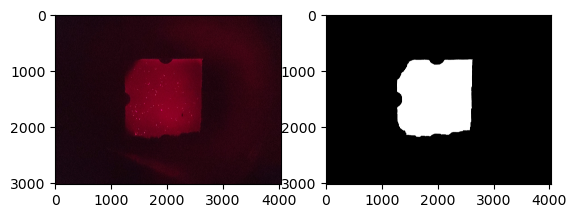

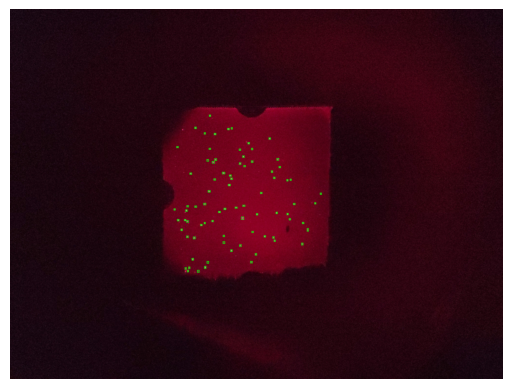

{'tile_grid_size': 416, 'tile_overlap_ratio': 0.25, 'conf_threshold': 0.25, 'nms_threshold': 0.1, 'num_pos_wells': 79}


In [346]:
display(image_file_path)